In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy
import pickle
import pefile
import sklearn.ensemble as ek
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import ElasticNet
import time

In [2]:
# Input Dataset 

DM = pd.read_parquet("C:\\Data Raihan\\Penelitian Threshold\\Dataset\\CCCS-CIC-AndMal-2020\\cicandmal2020-dynamic.parquet")

In [3]:
DM.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53439 entries, 0 to 53438
Data columns (total 145 columns):
 #    Column                                                                              Non-Null Count  Dtype 
---   ------                                                                              --------------  ----- 
 0    Memory_PssTotal                                                                     53439 non-null  int32 
 1    Memory_PssClean                                                                     53439 non-null  int32 
 2    Memory_SharedDirty                                                                  53439 non-null  int32 
 3    Memory_PrivateDirty                                                                 53439 non-null  int32 
 4    Memory_SharedClean                                                                  53439 non-null  int32 
 5    Memory_PrivateClean                                                                 53439 non

In [4]:
# Menampilkan nilai unik pada kolom Category, Family, dan Label
unique_category = DM['Category'].unique()
unique_family = DM['Family'].unique()
unique_label = DM['Label'].unique()

print("Unique Categories:", unique_category)
print("Unique Families:", unique_family)
print("Unique Labels:", unique_label)

Unique Categories: ['Trojan_Spy' 'FileInfector' 'Zero_Day' 'Backdoor' 'Ransomware'
 'No_Category' 'Trojan_SMS' 'Trojan_Dropper' 'Trojan_Banker' 'Scareware'
 'PUA' 'Adware' 'Riskware' 'Trojan']
Unique Families: ['smsthief' 'sandr' 'smforw' ... 'pesabti' 'mycompany' 'koomer']
Unique Labels: ['Trojan_Spy_before_reboot_Cat' 'FileInfector_after_reboot_Cat'
 'Zero_Day_after_reboot_Cat' 'Trojan_Spy_after_reboot_Cat'
 'Backdoor_before_reboot_Cat' 'Ransomware_after_reboot_Cat'
 'Ransomware_before_reboot_Cat' 'No_Category_before_reboot_Cat'
 'Trojan_SMS_after_reboot_Cat' 'Zero_Day_before_reboot_Cat'
 'Backdoor_after_reboot_Cat' 'Trojan_Dropper_after_reboot_Cat'
 'Trojan_Banker_after_reboot_Cat' 'Scareware_before_reboot_Cat'
 'PUA_after_reboot_Cat' 'Scareware_after_reboot_Cat'
 'PUA_before_reboot_Cat' 'Adware_before_reboot_Cat'
 'Riskware_before_reboot_Cat' 'Riskware_after_reboot_Cat'
 'Trojan_Banker_before_reboot_Cat' 'Trojan_SMS_before_reboot_Cat'
 'FileInfector_before_reboot_Cat' 'Trojan_befor

In [5]:
# Definisikan kategori benign dan malware
benign_categories = ['Adware', 'Riskware', 'PUA', 'No_Category']
malware_categories = ['Trojan_Spy', 'FileInfector', 'Zero_Day', 'Backdoor', 
                      'Ransomware', 'Trojan_SMS', 'Trojan_Dropper', 'Trojan_Banker', 
                      'Scareware', 'Trojan']

# Relabeling ke dalam kelas binari: 'Benign' dan 'Malware'
DM['Binary_Label'] = DM['Category'].apply(lambda x: 'Benign' if x in benign_categories else 'Malware')

# Cek hasil unique Binary_Label setelah relabeling
unique_binary_labels = DM['Binary_Label'].unique()
print("Unique Binary Labels after relabeling:", unique_binary_labels)

Unique Binary Labels after relabeling: ['Malware' 'Benign']


In [6]:
#Feature Selection
features_to_drop = ['Hash', 'Category', 'Family', 'Label', 'Network_TotalReceivedBytes', 'Binary_Label']

# Droping specified columns and target variable
X = DM.drop(features_to_drop, axis=1).values    
y = DM['Binary_Label'].values

In [7]:
#Remove Nan
X = pd.DataFrame(X).dropna()
y = y[X.index]

In [8]:
# Apply Min-Max scaling to make X non-negative
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Encoding y dengan LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [10]:
# Elastic Net - Embedded
elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.05)
elastic_net.fit(X_scaled, y_encoded)

ElasticNet(alpha=0.01, l1_ratio=0.05)

In [11]:
# Mendapatkan support dari Elastic Net (fitur yang koefisiennya tidak 0)
elastic_net_support = np.where(elastic_net.coef_ != 0)[0]

# Mengambil nama kolom dari X yang sudah difilter
filtered_columns = DM.drop(features_to_drop, axis=1).columns

features = []
for idx in elastic_net_support:
    print(f"Feature {filtered_columns[idx]} dengan koefisien Elastic Net {elastic_net.coef_[idx]}")
    features.append(filtered_columns[idx])

Feature Memory_PssClean dengan koefisien Elastic Net -0.07547610134576217
Feature Memory_SharedClean dengan koefisien Elastic Net -0.2412079769203619
Feature Memory_PrivateClean dengan koefisien Elastic Net -0.09376121747119641
Feature Memory_HeapSize dengan koefisien Elastic Net 0.015270876333250567
Feature Memory_HeapAlloc dengan koefisien Elastic Net 0.03235923615338048
Feature Memory_DeathRecipients dengan koefisien Elastic Net -0.10857574792654862
Feature Memory_OpenSSLSockets dengan koefisien Elastic Net -0.013949007290748905
Feature API_Process_android.app.ActivityManager_killBackgroundProcesses dengan koefisien Elastic Net 0.07071634130901254
Feature API_FileIO_android.content.ContextWrapper_openFileOutput dengan koefisien Elastic Net 0.031364984267458894
Feature API_FileIO_android.content.ContextWrapper_deleteFile dengan koefisien Elastic Net -0.1677024496662129
Feature API_Database_android.content.ContextWrapper_databaseList dengan koefisien Elastic Net -0.01909472734233645
F

In [12]:
# Tentukan 1% dari total dataset
total_samples = int(len(DM) * 0.01)

# Ambil sampel secara acak dari kedua kelas dengan jumlah yang seimbang
sampled_data = DM.groupby('Binary_Label').apply(lambda x: x.sample(n=int(total_samples / 2), random_state=42)).reset_index(drop=True)

# Cek distribusi kelas setelah sampling
print(sampled_data['Binary_Label'].value_counts())

hasil_threshold = []

Binary_Label
Benign     267
Malware    267
Name: count, dtype: int64


C:\Users\Muhammad Raihan\AppData\Local\Temp\ipykernel_19612\1873401016.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = DM.groupby('Binary_Label').apply(lambda x: x.sample(n=int(total_samples / 2), random_state=42)).reset_index(drop=True)


In [13]:
def Thresholding(threshold, feature):
    # Mengukur waktu mulai
    start_time = time.time()

    # Melakukan thresholding
    BenignDataThreshold = sampled_data[sampled_data[feature] > int(threshold)]
    MalwareDataThreshold = sampled_data[sampled_data[feature] <= int(threshold)]

    # Untuk BenignDataThreshold
    y_true_benign = ["Benign"] * len(BenignDataThreshold)
    y_pred_benign = BenignDataThreshold["Binary_Label"]

    # Untuk MalwareDataThreshold
    y_true_malware = ["Malware"] * len(MalwareDataThreshold)
    y_pred_malware = MalwareDataThreshold["Binary_Label"]

    # Menyatukan true labels dan predicted labels
    y_true = y_true_benign + y_true_malware
    y_pred = y_pred_benign.tolist() + y_pred_malware.tolist()

    # Menghitung confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Menghitung Precision, Recall, F1-score, dan Accuracy
    PrecisionThreshold = tp / (tp + fp) if (tp + fp) != 0 else 0
    RecallThreshold = tp / (tp + fn) if (tp + fn) != 0 else 0
    F1ScoreThreshold = 2 * ((PrecisionThreshold * RecallThreshold) / (PrecisionThreshold + RecallThreshold)) if (PrecisionThreshold + RecallThreshold) != 0 else 0
    AccuracyThreshold = (tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) != 0 else 0

    # Mengukur waktu selesai
    elapsed_time = time.time() - start_time

    # Menyimpan hasil dalam format satu baris untuk setiap threshold
    hasil_threshold.append([feature, threshold, PrecisionThreshold, RecallThreshold, F1ScoreThreshold, AccuracyThreshold, elapsed_time])

# Lakukan thresholding pada fitur yang dipilih oleh Chi-Square Test
for feature in tqdm(features, desc='Progress'):
    # Pastikan bahwa Min dan Max adalah nilai numerik
    Max = pd.to_numeric(sampled_data[feature], errors='coerce').max()
    Min = pd.to_numeric(sampled_data[feature], errors='coerce').min()

    # Cek apakah Min dan Max valid (bukan NaN)
    if pd.notna(Min) and pd.notna(Max):
        for x in range(int(Min), int(Max + 1)):
            Thresholding(x, feature)
    else:
        print(f"Fitur {feature} mengandung nilai non-numerik dan tidak dapat diproses.")

print(hasil_threshold)

# Mengubah hasil menjadi DataFrame dengan kolom yang sesuai
hasil_threshold_df = pd.DataFrame(hasil_threshold, columns=['Feature', 'Threshold', 'Precision', 'Recall', 'F1_Score', 'Accuracy', 'Elapsed_Time'])

# Simpan DataFrame ke CSV
hasil_threshold_df.to_csv('Elastic Net.csv', index=False)

print("Hasil threshold disimpan ke dalam file 'Elastic Net.csv'")

Progress: 100%|█████████████████████████████████████████████████████████████████████| 36/36 [2:21:16<00:00, 235.46s/it]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Hasil threshold disimpan ke dalam file 'Elastic Net.csv'


In [14]:
HasilThreshold = pd.read_csv("C:\\Data Raihan\\Penelitian Threshold\\14-10-2024\\Elastic Net.csv")
HasilThreshold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3094651 entries, 0 to 3094650
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Feature       object 
 1   Threshold     int64  
 2   Precision     float64
 3   Recall        float64
 4   F1_Score      float64
 5   Accuracy      float64
 6   Elapsed_Time  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 165.3+ MB


In [15]:
# Inisialisasi variabel winner untuk masing-masing metrik
winner_precision = ['', '', 0]  # [feature, threshold, value]
winner_recall = ['', '', 0]
winner_f1_score = ['', '', 0]
winner_accuracy = ['', '', 0]
winner_run_time = ['', '', float('inf')]  # Memilih yang terendah, jadi diinisialisasi dengan tak hingga

# Iterasi melalui setiap baris di HasilThreshold
for index, result in HasilThreshold.iterrows():
    # result['Feature'], result['Threshold'], result['Precision'], 
    # result['Recall'], result['F1_Score'], result['Accuracy'],
    # result['Elapsed_Time']
    
    # Membandingkan Precision
    if result['Precision'] > winner_precision[2]:  # result['Precision']
        winner_precision = [result['Feature'], result['Threshold'], result['Precision']]  # [feature, threshold, Precision]
    
    # Membandingkan Recall
    if result['Recall'] > winner_recall[2]:  # result['Recall']
        winner_recall = [result['Feature'], result['Threshold'], result['Recall']]  # [feature, threshold, Recall]

    # Membandingkan F1-score
    if result['F1_Score'] > winner_f1_score[2]:  # result['F1_Score']
        winner_f1_score = [result['Feature'], result['Threshold'], result['F1_Score']]  # [feature, threshold, F1 Score]

    # Membandingkan Accuracy
    if result['Accuracy'] > winner_accuracy[2]:  # result['Accuracy']
        winner_accuracy = [result['Feature'], result['Threshold'], result['Accuracy']]  # [feature, threshold, Accuracy]

    # Membandingkan waktu running (run_time) untuk threshold tercepat (terkecil)
    if result['Elapsed_Time'] < winner_run_time[2]:  # result['Elapsed_Time']
        winner_run_time = [result['Feature'], result['Threshold'], result['Elapsed_Time']]  # [feature, threshold, elapsed_time]

In [16]:
def plot_metrics_for_winner(winner, metric_name):
    winner_feature, winner_threshold = winner[0], winner[1]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = HasilThreshold[HasilThreshold['Feature'] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan kolom metrik
    thresholds = winner_results['Threshold'].tolist()  # Threshold
    precision = winner_results['Precision'].tolist()   # Precision
    recall = winner_results['Recall'].tolist()         # Recall
    f1_score = winner_results['F1_Score'].tolist()     # F1 Score
    accuracy = winner_results['Accuracy'].tolist()      # Accuracy

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracy, label='Accuracy', marker='o')
    plt.plot(thresholds, precision, label='Precision', marker='o')
    plt.plot(thresholds, recall, label='Recall', marker='o')
    plt.plot(thresholds, f1_score, label='F1 Score', marker='o')

    plt.title(f'{metric_name} Winner: Metrics vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
def plot_runtime_for_winner(winner):
    winner_feature, winner_threshold = winner[0], winner[1]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = HasilThreshold[HasilThreshold['Feature'] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan run_time
    thresholds = winner_results['Threshold'].tolist()    # Threshold
    run_time = winner_results['Elapsed_Time'].tolist()   # Run Time (elapsed_time)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, run_time, label='Run Time', marker='o')

    plt.title(f'Run Time Winner: Run Time vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Run Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

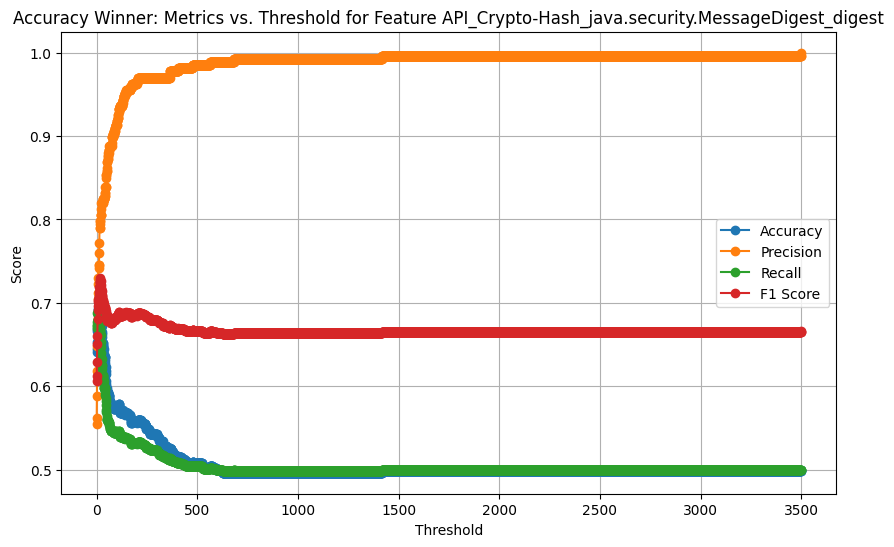

In [18]:
# Plot untuk Accuracy Winner
plot_metrics_for_winner(winner_accuracy, 'Accuracy')

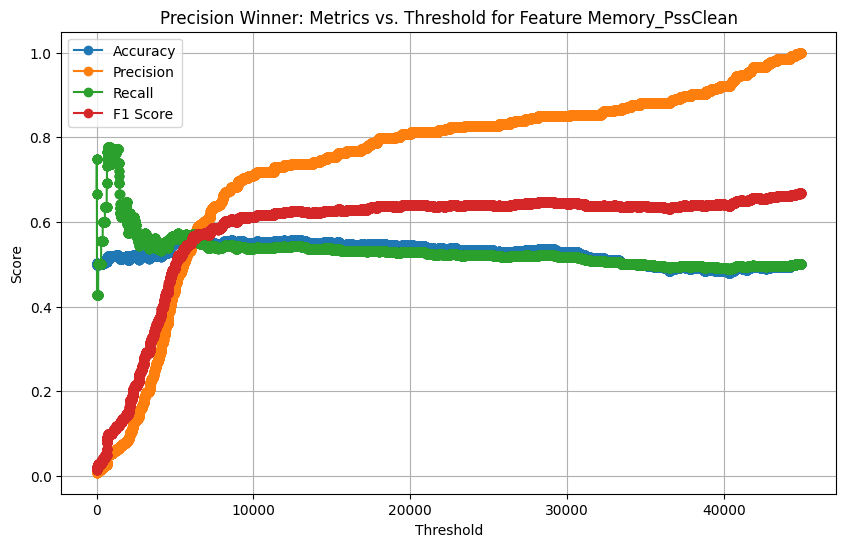

In [19]:
# Plot untuk Precision Winner
plot_metrics_for_winner(winner_precision, 'Precision')

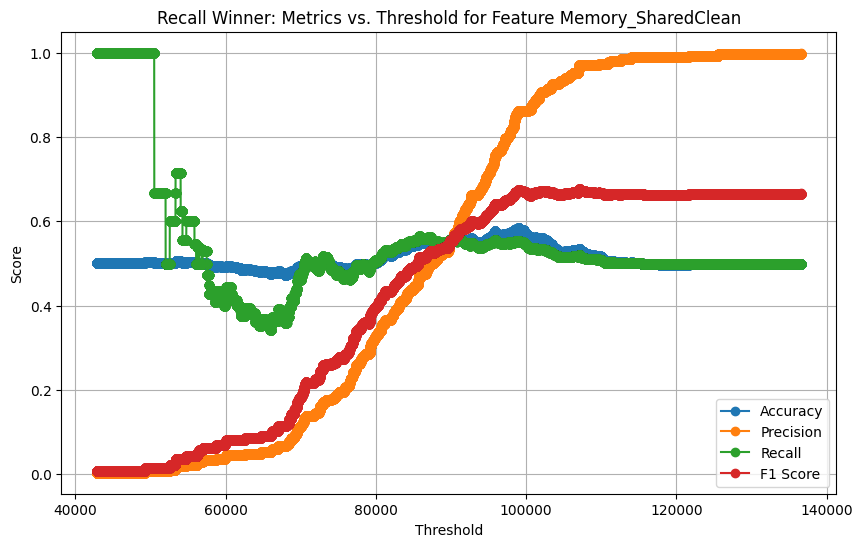

In [20]:
# Plot untuk Recall Winner
plot_metrics_for_winner(winner_recall, 'Recall')

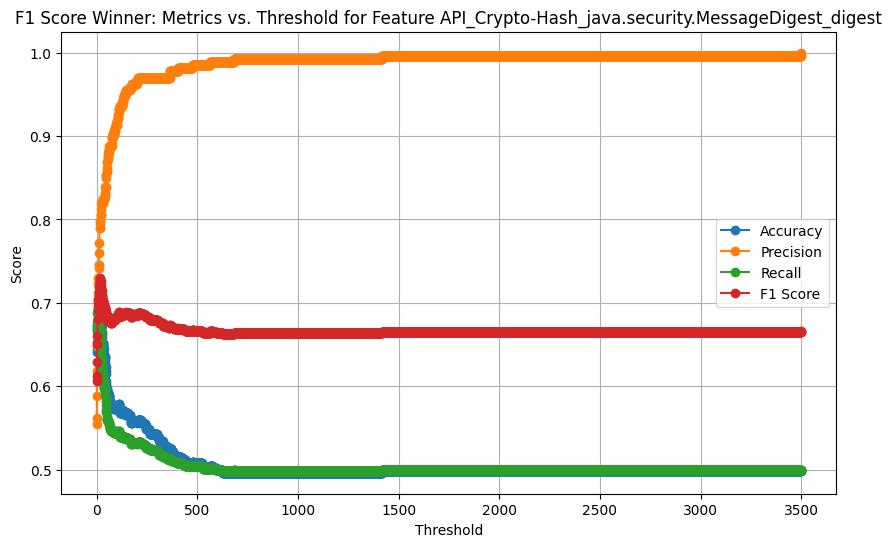

In [21]:
# Plot untuk F1-Score Winner
plot_metrics_for_winner(winner_f1_score, 'F1 Score')

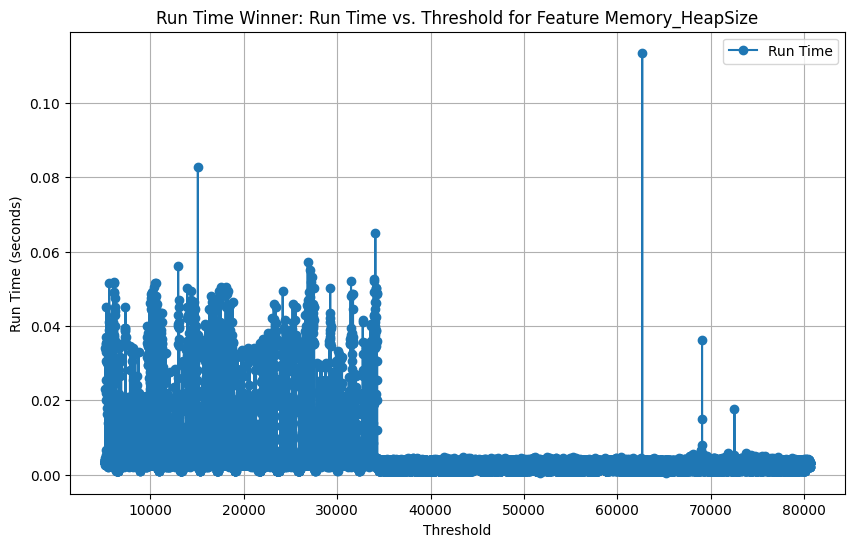

In [22]:
# Plot untuk Run Time Winner
plot_runtime_for_winner(winner_run_time)

In [23]:
# Output untuk setiap metrik
print(f"Precision terbaik dicapai dengan fitur {winner_precision[0]} dan threshold {winner_precision[1]}, menghasilkan precision {winner_precision[2]}.")
print(f"Recall terbaik dicapai dengan fitur {winner_recall[0]} dan threshold {winner_recall[1]}, menghasilkan recall {winner_recall[2]}.")
print(f"F1-score terbaik dicapai dengan fitur {winner_f1_score[0]} dan threshold {winner_f1_score[1]}, menghasilkan F1-score {winner_f1_score[2]}.")
print(f"Akurasi terbaik dicapai dengan fitur {winner_accuracy[0]} dan threshold {winner_accuracy[1]}, menghasilkan akurasi {winner_accuracy[2]}.")
print(f"Waktu running tercepat dicapai dengan fitur {winner_run_time[0]} dan threshold {winner_run_time[1]}, dengan waktu running {winner_run_time[2]} detik.")

Precision terbaik dicapai dengan fitur Memory_PssClean dan threshold 44796, menghasilkan precision 1.0.
Recall terbaik dicapai dengan fitur Memory_SharedClean dan threshold 42816, menghasilkan recall 1.0.
F1-score terbaik dicapai dengan fitur API_Crypto-Hash_java.security.MessageDigest_digest dan threshold 15, menghasilkan F1-score 0.7301038062283738.
Akurasi terbaik dicapai dengan fitur API_Crypto-Hash_java.security.MessageDigest_digest dan threshold 15, menghasilkan akurasi 0.7078651685393258.
Waktu running tercepat dicapai dengan fitur Memory_HeapSize dan threshold 51725, dengan waktu running 0.0005021095275878 detik.
